# `SuchTree`

I didn't want to write this. I really didn't.

In [3]:
%pylab inline
import seaborn

Populating the interactive namespace from numpy and matplotlib


In [4]:
from SuchTree import SuchTree

### Calculating distances

`SuchTree` has two ways to calculate distances. One pair at a time using 
`SuchTree.distance()`, or several large groups at once using `SuchTree.distances()`. 
The later avoids the interpreter's overhead and is much faster.

Note that the dendrograms in the cluster maps shown below are re-computed from 
the distances in the matrix using neighbor joining, and so they do not exactly match
the phylogeny. Send complaints to the authors of `seaborn`. 

In [11]:
from ete2 import Tree, TreeStyle, NodeStyle, TextFace
from numpy import linspace

ts = TreeStyle()
ts.mode = 'r'
ts.show_leaf_name = True
ts.branch_vertical_margin = 2
ts.scale = 10
ts.show_leaf_name = False
ts.show_scale = False

nstyle = NodeStyle()
nstyle['size'] = 0

ete_tree = Tree( 'SuchTree/tests/test.tree' )

for node in ete_tree.traverse() :
    node.set_style(nstyle)
    if node.is_leaf :
        tf = TextFace( node.name.replace('_',' ').replace('\'','') )
        tf.fsize = 10
        tf.hz_align = 100
        node.add_face( tf, 0 )

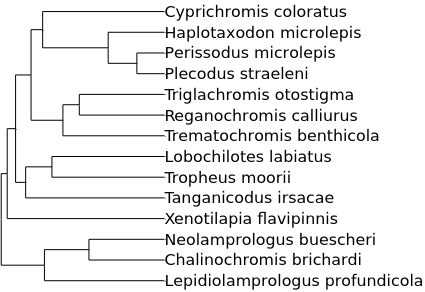

In [12]:
ete_tree.render("%%inline", w=120, units="mm", tree_style=ts)

In [12]:
T = SuchTree( '../SuchTree/tests/test.tree')

In [13]:
D1 = zeros( ( len(T.leafs),len(T.leafs) ) )
for i,a in enumerate(T.leafs.values()) :
    for j,b in enumerate( T.leafs.values() ) :
        D1[i,j] = T.distance( a, b )

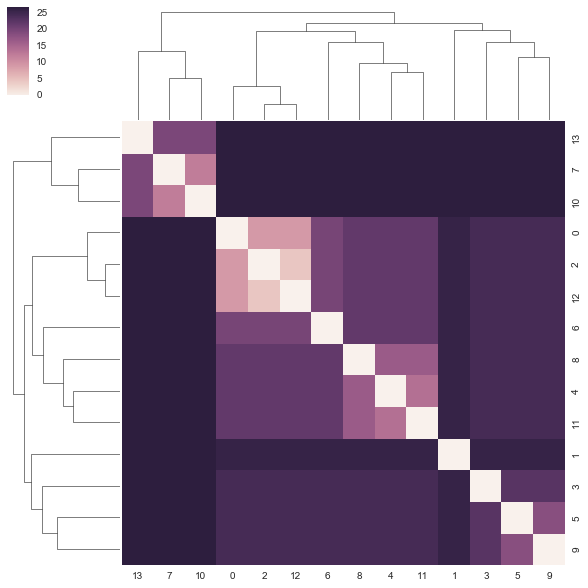

In [14]:
seaborn.clustermap(D1)

In [15]:
D2_list = []
for i,a in enumerate(T.leafs.values()) :
    for j,b in enumerate( T.leafs.values() ) :
        D2_list.append( ( a, b ) )
D2_array = array( D2_list )
D2 = T.distances( D2_array )
D2 = D2.reshape( ( len(T.leafs), len(T.leafs) ) )

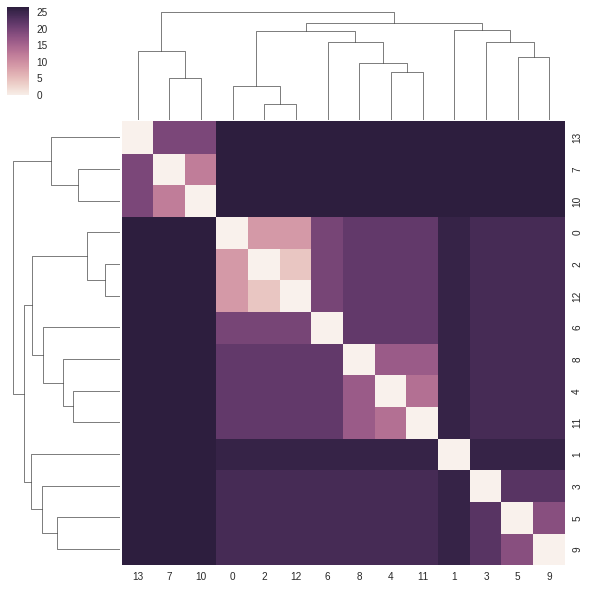

In [17]:
seaborn.clustermap(D2)

### Loading data from URLs

SuchTree can also import data from the internets. Here is the distance matrix for 
the penguins, from the [Global Phylogeny of Birds](http://birdtree.org/).

In [16]:
T3 = SuchTree( 'http://litoria.eeb.yale.edu/bird-tree/archives/PatchClade/Stage2/set1/Spheniscidae.tre' )

D3_list = []
for i,a in enumerate(T3.leafs.values()) :
    for j,b in enumerate( T3.leafs.values() ) :
        D3_list.append( ( a, b ) )
D3_array = array( D3_list )
D3 = T3.distances( D3_array )
D3 = D3.reshape( ( len(T3.leafs), len(T3.leafs) ) )

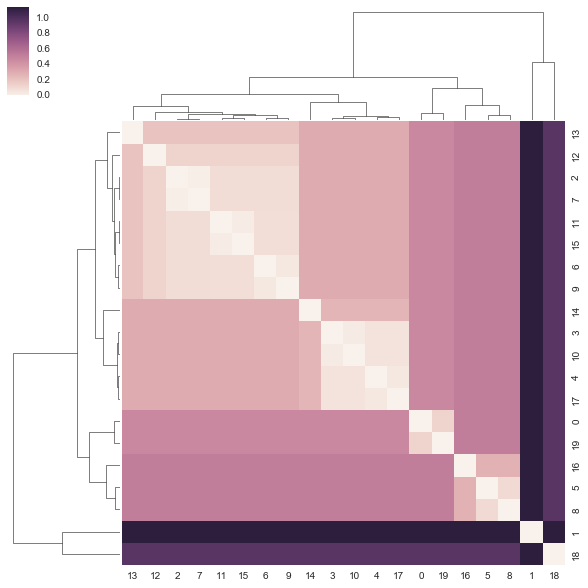

In [17]:
seaborn.clustermap(D3)

### Comparing the topologies of two large trees

Here, we use `SuchTree` to compare the topology of two trees containing the same taxa
but constructed with different methods ([`FastTree`](http://www.microbesonline.org/fasttree/) and 
[`neighbor-joining`](https://en.wikipedia.org/wiki/Neighbor_joining)). One million random pairs are 
sampled from each tree.

On my [rather elderly laptop](https://en.wikipedia.org/wiki/ThinkPad_X_Series#X200s), 
the distance calculations in both trees are completed in 22 seconds (most of which
is mapping the names to the node indicies).

In [20]:
T1 = SuchTree( 'http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_unique_2_clustalo_fasttree.tree' )
T2 = SuchTree( 'http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_unique_2_clustalo_fasttree_nj.tree' )

print 'nodes : %d, leafs : %d' % ( T1.length, len(T1.leafs) )
print 'nodes : %d, leafs : %d' % ( T2.length, len(T2.leafs) )

nodes : 108653, leafs : 54327
nodes : 108653, leafs : 54327


In [25]:
import random

N = 1000000

v = T1.leafs.keys()

pairs = []
for i in range(N) :
    pairs.append( ( random.choice( v ), random.choice( v ) ) )

%time D1, D2 = T1.distances_by_name( pairs ), T2.distances_by_name( pairs)

CPU times: user 9.98 s, sys: 0 ns, total: 9.98 s
Wall time: 9.98 s


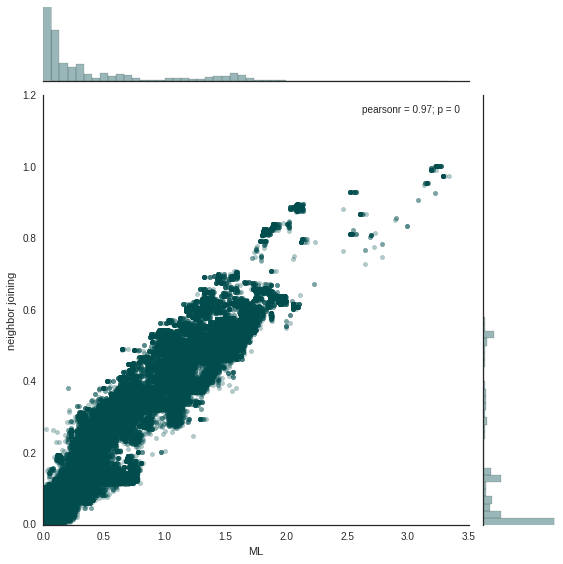

In [22]:
import pandas as pd

df = pd.DataFrame( { 'ML' : D1, 'neighbor joining' : D2 } )

with seaborn.axes_style("white"):
    seaborn.jointplot( 'ML', 'neighbor joining', data=df, color=seaborn.xkcd_rgb['dark teal'], alpha=0.3,
                       xlim=(0,3.5), ylim=(0,1.2), size=8 )

In [86]:
from scipy.stats import spearmanr, kendalltau, pearsonr

print 'Spearman\'s rs : %0.3f' % spearmanr( D1, D2 )[0]
print 'Kendall\'s tau : %0.3f' % kendalltau( D1, D2 )[0]
print 'Pearson\'s r   : %0.3f' % pearsonr( D1, D2 )[0]

Spearman's rs : 0.876
Kendall's tau : 0.708
Pearson's r   : 0.969


### Running with multiple threads

If you use `SuchTree.distances()` to compute a bunch of distances at once,
these calculations can run outside of Python's 
[global interpreter lock](https://lbolla.info/blog/2013/12/23/python-threads-cython-gil).
You can parallelize with [Threads](https://docs.python.org/2/library/threading.html),
which are easier to use than the
[multiprocessing](https://docs.python.org/2/library/multiprocessing.html). 

`SuchTree` intentionally does not allow the user to alter trees once they are created,
and so distance calculations are always thread safe. This makes it possible to use only 
*one* instance of a tree for all threads, which ought to give you the best chance of
keeping it within L2 cache.

In [16]:
from threading import Thread
from Queue import Queue

n = 2
m = 12

work_q = Queue()
done_q = Queue()

for i in xrange( m ) :
    work_q.put( pairs )

for i in xrange( n ) :
    work_q.put( 'STOP' )
    
def worker( work_q, done_q ) :
    for task in iter( work_q.get, 'STOP' ) :
        D1 = T1.distances_by_name( task )
        D2 = T2.distances_by_name( task )
        r = correlation( D1, D2 )
        done_q.put( r )
    return True

threads = []

for i in xrange( n ) :
    thread = Thread( target=worker, args=( work_q, done_q ) )
    thread.start()
    threads.append( thread )
    
for thread in threads :
    thread.join()

done_q.put( 'STOP' )

for r in iter( done_q.get, 'STOP' ) :
    print r

0.968953943425
0.968953943425
0.968953943425
0.968953943425
0.968953943425
0.968953943425
0.968953943425
0.968953943425
0.968953943425
0.968953943425
0.968953943425
0.968953943425
